# Factors influencing the acceptance of applications

In the following we're going to take of look what factors are influence whether an application is certified or declined.


In [446]:
import cleanup
import pandas as pd

In [447]:
# cleanup.generate_cleaned_df()


In [448]:

col_list = ["case_status", "country_of_citizenship"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

Firstly we're going to peek into the overall situation.

<AxesSubplot:ylabel='case_status'>

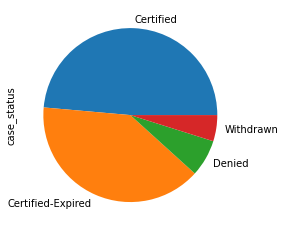

In [449]:
visas_df["case_status"].value_counts().plot(kind='pie')

To explain the possible values.

- Certified:
    - A “certified” status indicates the labor certification is granted. The certified application and a complete Final Determination form will be sent to the employer, or, if appropriate, to the employer’s agent or attorney, indicating the employer may file all the documents with the appropriate office in the Department of Homeland Security (DHS).
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM certified status means it has been approved and is valid for 180 days from the date of approval.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Certified-Expired:
    - After the Labor Certification is approved by the DOL, an Immigrant Petition related to the Labor Certification should be filed with the U.S.C.I.S. before the expiration of the labor certification. The certification has a validity period of 180-days and expires if not submitted to USCIS within this period.
    - https://immsolutionsllc.com/work-visas/perm-labor-certification
    - PERM certified expired means that PERM was approved but was not used within 6 months to file i140 with USCIS.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Denied:
    - A “denied” status indicates the application is denied. A Final Determination form, stating the reasons for the determination and advising the employer of how to request review, should the employer choose to do so, will be sent to the employer. The Final Determination must be included in any request for review, therefore, the employer must wait to receive the form before making such a request. The employer is also advised to wait for the Final Determination before filing a new application for the same alien to avoid repeating errors made in the original application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was denied by DOL.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Withdrawn:
    - A “withdrawn” status indicates the employer has withdrawn the application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was withdrawn by employer.
    - https://www.am22tech.com/uscis/perm-processing-time/

Regarding the analysis question, factors influencing the acceptance of applications, some changes eill be made in the dataset.

"Certified-Expired" will be changed into "Certified"
And columns containing "Withdrawn" will be deleted.


<AxesSubplot:ylabel='case_status'>

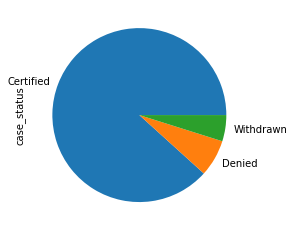

In [450]:
visas_df["case_status"] = visas_df["case_status"].str.replace('Certified-Expired', 'Certified')

visas_df["case_status"].value_counts().plot(kind='pie')

In [451]:
visas_df = visas_df[~visas_df["case_status"].str.contains("Withdrawn", na=False)]


<AxesSubplot:ylabel='case_status'>

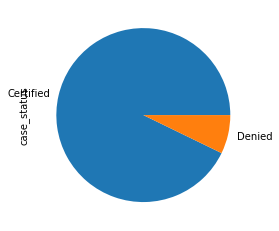

In [452]:
visas_df["case_status"].value_counts().plot(kind='pie')

<AxesSubplot:>

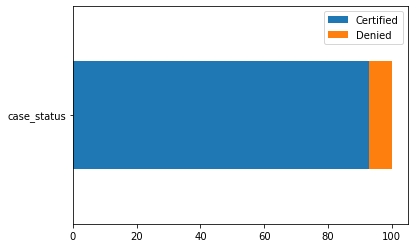

In [453]:


d = visas_df["case_status"].value_counts(normalize=True).mul(100)

d.to_frame().T.plot.barh(stacked=True)

In [454]:
top20 = visas_df["country_of_citizenship"].value_counts().nlargest(20).reset_index()

top20.columns = ['country_of_citizenship', 'count']

In [455]:
top20.head()


,country_of_citizenship,count
0,INDIA,196585
1,CHINA,27454
2,SOUTH KOREA,22254
3,CANADA,14109
4,MEXICO,8564


In [456]:
df_top = visas_df.loc[visas_df['country_of_citizenship'].isin(top20.reset_index()['country_of_citizenship'])]

In [457]:
df_top.head()


,country_of_citizenship,case_status
2,INDIA,Certified
3,SOUTH KOREA,Certified
4,CANADA,Certified
6,MEXICO,Certified
7,CANADA,Denied


In [458]:

s = df_top["case_status"].groupby(df_top["country_of_citizenship"]).value_counts(normalize=True).mul(100).reset_index(name='counts')

In [459]:
s.head()

s = s.pivot(index="country_of_citizenship", columns = "case_status", values = "counts")

In [460]:
df = s.merge(top20, left_on='country_of_citizenship', right_on='country_of_citizenship')
df = df.sort_values(by=['count'], ascending=False).reset_index()

df = df.drop(['index'], axis=1)
#df = df.drop(['count'], axis=1)
df.head()

,country_of_citizenship,Certified,Denied,count
0,INDIA,95.158328,4.841672,196585
1,CHINA,94.172070,5.827930,27454
2,SOUTH KOREA,88.384111,11.615889,22254
3,CANADA,93.691970,6.308030,14109
4,MEXICO,76.389538,23.610462,8564


In [461]:
# df = df.set_index("country_of_citizenship")


In [468]:
df = df.set_index("country_of_citizenship")

In [469]:
df.head()

,Certified,Denied,count
country_of_citizenship,,,
INDIA,95.158328,4.841672,196585
CHINA,94.172070,5.827930,27454
SOUTH KOREA,88.384111,11.615889,22254
CANADA,93.691970,6.308030,14109
MEXICO,76.389538,23.610462,8564


<AxesSubplot:xlabel='country_of_citizenship'>

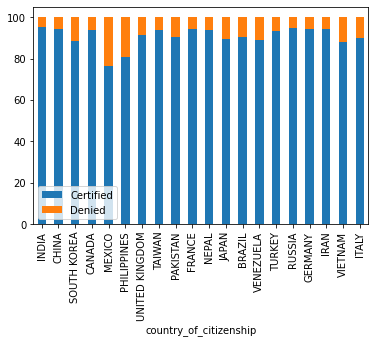

In [471]:

df[['Certified','Denied']].plot.bar(stacked=True)